# Optimisation
Note that, to use this notebook, the notebook "rose_demo" has to be completed

In [1]:
import os
import pickle
import json

import numpy as np
import matplotlib.pyplot as plt

# import rose packages
from rose.optimisation.optimisation import Optimisation, OptimisationModelPart,ModelResults
from rose.utils import signal_proc
from data_proc import ricardo, SoS

# Read SoS

In [2]:

sos_dir = "data/SoS"
sos = SoS.ReadSosScenarios(os.path.join(sos_dir, "soilprofiles.csv"),
                               os.path.join(sos_dir, "20201102_Prorail_parameters_SOS.csv"),
                               os.path.join(sos_dir, "segments.csv"),
                               os.path.join(sos_dir, "Segments_TKI_v2.shp"))
sos.create_segments()
sos.dump(os.path.join(sos_dir, "SOS.json"))


# Load SoS

In [3]:
with open(os.path.join(sos_dir, "SOS.json"), 'r') as f:
    sos_data = json.load(f)


# Read Ricardo data

In [4]:
ricardo_filenames = [r"data/Ricardo/Jan.json",
             r"data/Ricardo/Jun.json",
             ]
ricardo_output_fn = r"data/Ricardo/inframon.pickle"
ricardo.read_inframon(ricardo_filenames, ricardo_output_fn)

{'Jan': {'time': array([0.000000e+00, 4.000000e-03, 8.000000e-03, ..., 3.929992e+03,
         3.929996e+03, 3.930000e+03]),
  'coordinates': array([[161519.2775296 , 383816.20194915],
         [161519.27029807, 383816.20282985],
         [161519.26306654, 383816.20371054],
         ...,
         [123020.83006098, 484367.97697868],
         [123020.8285645 , 484367.98440619],
         [123020.82706802, 484367.9918337 ]]),
  'speed': array([1.931636  , 1.93704384, 1.94245168, ..., 1.74179859, 1.7283753 ,
         1.714952  ]),
  'acc_side_1': array([0.16322143, 0.10544159, 0.03208939, ..., 0.06827947, 0.06612804,
         0.07611204]),
  'acc_side_2': array([-0.31587233, -0.03515124,  0.01806325, ...,  0.02656312,
          0.02042447,  0.02461162]),
  'segment': array(['', '', '', ..., '', '', ''], dtype='<U12')},
 'Jun': {'time': array([0.000000e+00, 4.000000e-03, 8.000000e-03, ..., 3.938992e+03,
         3.938996e+03, 3.939000e+03]),
  'coordinates': array([[161514.07870791, 383849.23

# Load Ricardo data

In [5]:
ricardo_data = ricardo.load_inframon_data(ricardo_output_fn)

# Get SoS Coordinates


In [6]:
# get coordinates of a segment
segment = sos_data["Segment 1030"]
coordinates = np.array(list(segment.values())[0]['coordinates'])

# get coordinate limits
xlim = [min(coordinates[:,0]), max(coordinates[:,0])]
ylim = [min(coordinates[:,1]), max(coordinates[:,1])]



# Get Ricardo data within SoS limits

In [7]:
ricardo_data_within_bounds = ricardo.get_data_within_bounds(ricardo_data["Jan"], xlim, ylim)

# Check if data is valid
The train velocity should be relatively constant over the bounded track, such that the acceleration signal is representative for a certain train speed at that point of the track

## check train velocity

<IPython.core.display.Javascript object>


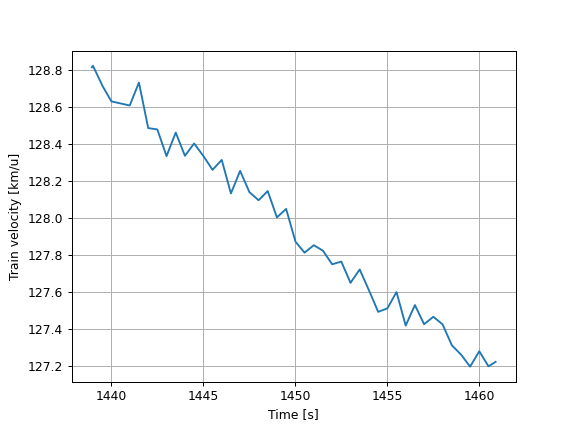

In [8]:
ricardo.plot_train_velocity(ricardo_data_within_bounds)
plt.grid()

## check acceleration signal

<IPython.core.display.Javascript object>


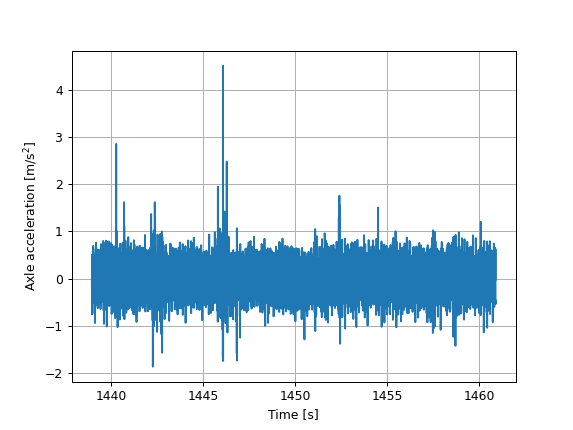

In [9]:
ricardo.plot_acceleration_signal(ricardo_data_within_bounds["time"], ricardo_data_within_bounds["acc_side_1"])
plt.grid()

# Filter inframon signal

In [10]:
# filter Ricardo measurements

# set filter settings
settings_filter = {"FS": 250,                   # acquisition frequency
                   "cut-off_high": 120,         # high cutoff frequency
                   "cut-off_low": 40,           # low cutoff frequency 
                   "n": 10,                     # order of the filter
                   "smoothing_distance": 10,    # distance of smoothed wavelength
                   }    

acceleration_data = ricardo_data_within_bounds["acc_side_1"]

# filter high frequencies
acc = signal_proc.filter_sig(acceleration_data,
                             settings_filter["FS"], settings_filter["cut-off_high"], settings_filter["n"],type="lowpass"
                             ).tolist()

# filter low frequencies
acc = signal_proc.filter_sig(acc,
                             settings_filter["FS"], settings_filter["cut-off_low"], settings_filter["n"],type="highpass"
                             ).tolist()

<IPython.core.display.Javascript object>


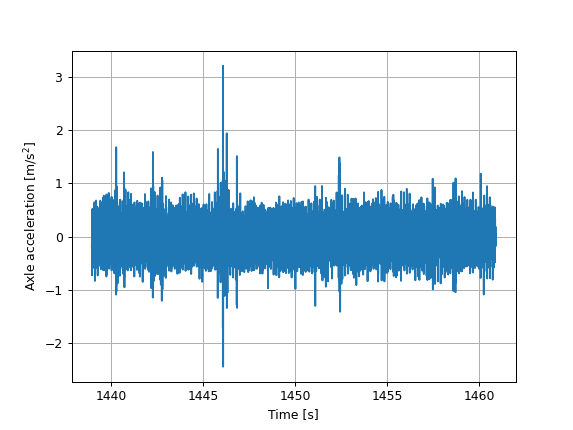

In [11]:
# plot filtered signal
ricardo.plot_acceleration_signal(ricardo_data_within_bounds["time"], acc)
plt.grid()

# Integrate acceleration signal to velocity signal



In [12]:
velocity = signal_proc.int_sig(acc, ricardo_data_within_bounds["time"], hp=True, mov=False, baseline=False, ini_cond=0)


<IPython.core.display.Javascript object>


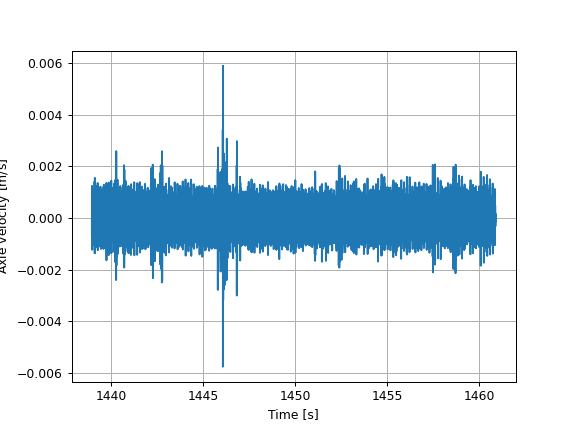

In [13]:
ricardo.plot_velocity_signal(ricardo_data_within_bounds["time"], acc)
plt.grid()

# Fast fourier transformation velocity signal

In [14]:
# fast fourier transformation of velocity signal
freq_velocity, ampl_velocity,_ = signal_proc.fft_sig(np.array(velocity), settings_filter["FS"])

# smooth signal
ampl_velocity = ricardo.smooth_signal_within_bounds_over_wave_length(ricardo_data_within_bounds, settings_filter["smoothing_distance"], ampl_velocity)

<IPython.core.display.Javascript object>


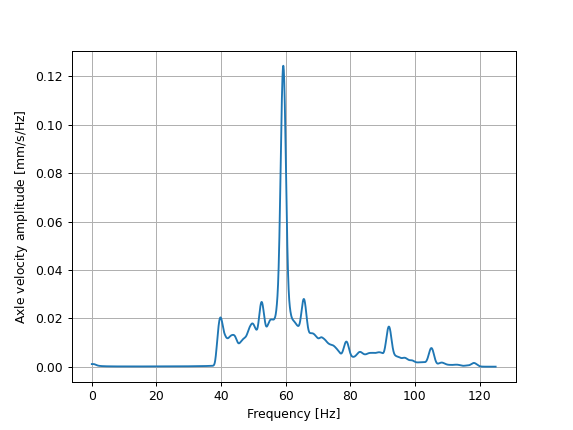

In [15]:
ricardo.plot_fft_velocity_signal(ricardo_data_within_bounds,acc, settings_filter["smoothing_distance"])
plt.grid()

In [16]:
# Get maximum velocity amplitude and corresponding frequency

m_to_mm = 1000

# maximum amplitude
max_vel_ampl = ampl_velocity[np.argmax(ampl_velocity)] * m_to_mm
# corresponding frequency
freq_at_max_vel = freq_velocity[np.argmax(ampl_velocity)]

In [17]:
max_vel_ampl, freq_at_max_vel 

(0.12437274245204365, 59.27647166028795)

# Check if frequency corresponds to the train speed
In this example, sleepers have a distance from eachother of 0.6 m. From the ricardo data, we can see that the average train speed over the segment is approximately 128 km/h. The frequency at the highest signal velocity should correspond to this train speed.

In [18]:
train_speed_mps = 128/3.6         # train speed in m/s
sleeper_dist = 0.6                # sleeper distance

load_frequency = train_speed_mps/sleeper_dist

In [19]:
load_frequency

59.25925925925927

# Update Rose model

In [20]:
# load results from rose demo

output_dir = "res"

with open(os.path.join(output_dir, "all_results.pickle"), 'rb') as f:
    coupled_model = pickle.load(f)["coupled_model"]


In [21]:
coupled_model.train.velocities

array([ 0.        ,  0.        ,  0.        , ..., 27.77777778,
       27.77777778, 27.77777778])

## reset velocities


In [22]:
# set velocity of train
velocities = np.ones(len(coupled_model.time)) * train_speed_mps

# prevent train from moving in initialisation phase
velocities[0:len(coupled_model.initialisation_time)] = 0
coupled_model.train.velocities = velocities

# Set optimisation parameters

In [23]:
optimisation = Optimisation()
optimisation.model=coupled_model
optimisation.observations =[freq_at_max_vel, max_vel_ampl]


optimisation_model_part = OptimisationModelPart()
optimisation_model_part.model_part = coupled_model.track.model_parts[4] # soil

# set the parameter in the corresponding model part which should be optimised
optimisation_model_part.optimisation_parameter_names = ["stiffness"]

# Set model result settings

## create a function to perform a fast fourier transformation on rose output

In [24]:
def results_function(signal, aq_freq):
    """
    Results function to be performed after a coupled calculation
    
    This functoin takes a signal, performs a fast fourier transformation and returns 
    the maximum amplitude in the frequency domain and the corresponding frequency 

    :param signal: signal to be processed
    :param aq_freq: aquisition frequency
    :return:
    """
    import rose.utils.signal_proc as signal_proc
    import matplotlib.pyplot as plt
    
    # filter signal
    signal2 = signal_proc.filter_sig(signal[:,0], aq_freq[0], 40, 6, "highpass")
    
    # fast fourier transformation
    freq, ampl,_ = signal_proc.fft_sig(signal2, aq_freq[0])

    # get maximum amplitude and corresponding frequency
    max_ampl_idx = np.argmax(ampl)
    max_freq = freq[max_ampl_idx]
    max_ampl = ampl[max_ampl_idx]
    return max_freq, max_ampl

## the results to be transformed are the velocities in the front wheel of the train

In [28]:
coupled_model.velocities_out

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.79756552e-39,  2.56791447e-38,  5.43384746e-35, ...,
         4.25616734e-03, -6.62863997e-03, -6.05310589e-03],
       [-1.31139120e-37,  3.79900443e-36,  1.05267758e-34, ...,
         8.50235826e-03, -6.91294926e-03, -5.76330971e-03],
       ...,
       [ 2.90506837e-08,  9.62382640e-08, -5.69115073e-23, ...,
        -5.09891202e-03,  7.99529839e-03, -1.65522753e-03],
       [ 3.16828575e-08,  9.43628901e-08, -7.63664578e-23, ...,
        -5.12409283e-03,  7.95602329e-03, -1.83521438e-03],
       [ 3.42683532e-08,  9.23405446e-08, -9.57436036e-23, ...,
        -5.13924783e-03,  7.90095379e-03, -2.00799549e-03]])

## get the vertical displacement degree of freedom index of the front wheel of the train

In [32]:
result_index = coupled_model.train.wheels[-1].nodes[0].index_dof[1]

In [33]:
coupled_model.velocities_out[result_index,:]

array([-2.48144034e-07,  3.87919286e-07,  3.70420204e-22, ...,
        5.23280578e-02,  5.37859872e-03, -1.30952546e-03])

In [34]:
model_results = ModelResults()

# set name of result attribute as present in the coupled model
model_results.result_names = ["velocities_out"]
# set the index of the result to be used
model_results.result_indices = [result_index]
# set the timesteps to be used for the optimisation
model_results.time_step_indices = np.arange(int(len(coupled_model.initialisation_time)),int(len(coupled_model.time)))
# set result function
model_results.result_function = results_function

In [35]:
# calculate aquisition frequency
dt = np.diff(coupled_model.time)[-1]

aq_freq = 1/dt

# set model results arguments
model_results.args =[aq_freq]

## Initialise optimisation algorithm
The optimisation algorithm which is used is the levenberg marquart algorithm. Which is a gradient based algorithm which works efficiently when only a few parameters are to be optimised and the problem is not highly non-linear.

In [36]:
optimisation.model_results = [model_results]
optimisation.optimisation_model_parts = [optimisation_model_part]
optimisation.initialise()

## perform optimisation

In [37]:
initial_guess_stiffness = 5e7

In [ ]:
optimisation.least_square(np.array([initial_guess_stiffness]), ftol=1e-8)

Initialising train
Initialising track and subsoil
Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction
